In [1]:
from dataclasses import dataclass
from typing import Optional
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Distribution, MultivariateNormal, kl_divergence
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.datasets import make_moons
from tqdm import trange

# Model

In [2]:
@dataclass(kw_only=True)
class CVAEOutput:
    """
    Dataclass for CVAE output.
    
    Attributes:
        recog_pass (bool): Whether is a recognition pass or a generation pass
        x (torch.Tensor): input x
        y (torch.Tensor): input y
        z_prior_dist (torch.distributions.Distribution): Prior distribution of the latent variable z.
        z_prior_sample (torch.Tensor): Sampled value of the prior of latent variable z.
        z_recog_dist (torch.distributions.Distribution): Recognition distribution of the latent variable z.
        z_recog_sample (torch.Tensor): Sampled value of the recognition distribution of latent variable z.
        y_recon (torch.Tensor): The reconstructed y.
        loss (torch.Tensor): The overall loss of the CVAE.
        loss_recon (torch.Tensor): The reconstruction loss component of the CVAE loss.
        loss_kl (torch.Tensor): The KL divergence component of the CVAE loss.
        loss_gen (torch.Tensor): Same `loss_recon` but compute from a generation of `y`.
    """
    recog_pass: bool
    x: torch.Tensor
    y: torch.Tensor
    z_prior_dist: Optional[Distribution] = None
    z_prior_sample: Optional[torch.Tensor] = None
    z_recog_dist: Optional[Distribution] = None
    z_recog_sample: Optional[torch.Tensor] = None
    y_recon: Optional[torch.Tensor] = None
    
    loss: Optional[torch.Tensor] = None
    loss_recon: Optional[torch.Tensor] = None
    loss_kl: Optional[torch.Tensor] = None
    loss_gen: Optional[torch.Tensor] = None


class CVAE(nn.Module):
    """Conditional Variational Autoencoder (CVAE) class.

    Args:
        x_dim (int): Dimensionality of the condition x.
        y_dim (int): Dimensionality of the input/output data y.
        hidden_dim (int): Dimensionality of the hidden layers.
        latent_dim (int): Dimensionality of the latent space.
    """
    def __init__(
        self,
        x_dim: int,
        y_dim: int,
        latent_dim: int,
        prior_hidden_dim: int | list[int],
        gen_hidden_dim: int | list[int],
        recog_hidden_dim: int | list[int],
    ):
        super(CVAE, self).__init__()

        self.x_dim = x_dim
        self.y_dim = y_dim
        self.latent_dim = latent_dim
        self.prior_hidden_dim = prior_hidden_dim
        self.gen_hidden_dim = gen_hidden_dim
        self.recog_hidden_dim = recog_hidden_dim

        # Prior network: p(z|x)
        prior_layers_list = []
        if type(prior_hidden_dim) != list:
            prior_layers_list.append(nn.Linear(x_dim, prior_hidden_dim))
            prior_layers_list.append(nn.LeakyReLU())
            prior_layers_list.append(nn.Linear(prior_hidden_dim, 2 * latent_dim))
        else:
            self.hidden_dim = prior_hidden_dim.copy()
            prior_layers_list.append(nn.Linear(x_dim, prior_hidden_dim[0]))
            prior_layers_list.append(nn.LeakyReLU())
            for i in range(len(prior_hidden_dim[1:])):
                prior_layers_list.append(nn.Linear(prior_hidden_dim[i], prior_hidden_dim[i+1]))
                prior_layers_list.append(nn.LeakyReLU())
            prior_layers_list.append(nn.Linear(prior_hidden_dim[-1], 2 * latent_dim))
        
        self.prior_network = nn.Sequential(*prior_layers_list)

        # Generation network: p(y|x,z)
        gen_layers_list = []
        if type(gen_hidden_dim) != list:
            gen_layers_list.append(nn.Linear(x_dim + latent_dim, gen_hidden_dim))
            gen_layers_list.append(nn.LeakyReLU())
            gen_layers_list.append(nn.Linear(gen_hidden_dim, y_dim))
        else:
            self.gen_hidden_dim = gen_hidden_dim.copy()
            gen_layers_list.append(nn.Linear(x_dim + latent_dim, gen_hidden_dim[0]))
            gen_layers_list.append(nn.LeakyReLU())
            for i in range(len(gen_hidden_dim[1:])):
                gen_layers_list.append(nn.Linear(gen_hidden_dim[i], gen_hidden_dim[i+1]))
                gen_layers_list.append(nn.LeakyReLU())
            gen_layers_list.append(nn.Linear(gen_hidden_dim[-1], y_dim))
        
        self.gen_network = nn.Sequential(*gen_layers_list)

        if y_dim == 1:
            self.loss = nn.BCEWithLogitsLoss(reduction='sum')
        else:
            self.loss = nn.CrossEntropyLoss(reduction='sum')

        # Recognition/Inference network: p(z|x,y)
        recog_layers_list = []
        if type(recog_hidden_dim) != list:
            recog_layers_list.append(nn.Linear(x_dim + y_dim, recog_hidden_dim))
            recog_layers_list.append(nn.LeakyReLU())
            recog_layers_list.append(nn.Linear(recog_hidden_dim, 2 * latent_dim))
        else:
            self.recog_hidden_dim = recog_hidden_dim.copy()
            recog_layers_list.append(nn.Linear(x_dim + y_dim, recog_hidden_dim[0]))
            recog_layers_list.append(nn.LeakyReLU())
            for i in range(len(recog_hidden_dim[1:])):
                recog_layers_list.append(nn.Linear(recog_hidden_dim[i], recog_hidden_dim[i+1]))
                recog_layers_list.append(nn.LeakyReLU())
            recog_layers_list.append(nn.Linear(recog_hidden_dim[-1], 2 * latent_dim))
        
        self.recog_network = nn.Sequential(*recog_layers_list)

    def reconstruct(self, x: torch.Tensor, z: torch.Tensor, raw: bool = False):
        xz = torch.concatenate((x, z), dim=1)
        y_recon = self.gen_network(xz)
        if not raw:
            if self.y_dim == 1:
                y_recon = F.sigmoid(y_recon)
            else:
                y_recon = F.softmax(y_recon, dim=-1)
        return y_recon

    def recognize(self, x: torch.Tensor, y: torch.Tensor, eps: float = 1e-8):
        xy = torch.concatenate((x, y), dim=1)
        params = self.recog_network(xy)
        means = params[:, :self.latent_dim]
        covs = torch.diag_embed(torch.exp(params[:, self.latent_dim:]) + eps)
        return MultivariateNormal(means, covariance_matrix=covs)

    def prior(self, x: torch.Tensor, eps: float = 1e-8):
        params = self.prior_network(x)
        means = params[:, :self.latent_dim]
        covs = torch.diag_embed(torch.exp(params[:, self.latent_dim:]) + eps)
        return MultivariateNormal(means, covariance_matrix=covs)

    def forward(
        self,
        x: torch.Tensor,
        y: torch.Tensor,
        kl_weight: float = 1.0,
        compute_loss: bool = True,
    ):
        z_recog_dist = self.recognize(x, y)
        z = z_recog_dist.rsample()
        # Reconstruction of y
        if not compute_loss:
            y_recon = self.reconstruct(x, z)
            return CVAEOutput(
                recog_pass=True,
                x=x,
                y=y,
                z_recog_dist=z_recog_dist,
                z_recog_sample=z,
                y_recon=y_recon,
            )
        # Compute loss
        y_recon = self.reconstruct(x, z, raw=True)
        loss_recon = self.loss(y_recon, y).mean()
        z_prior_dist = self.prior(x)
        loss_kl = kl_divergence(z_recog_dist, z_prior_dist).mean()
        loss = loss_recon + kl_weight * loss_kl
        if self.y_dim == 1:
            y_recon = F.sigmoid(y_recon)
        else:
            y_recon = F.softmax(y_recon, dim=-1)
        return CVAEOutput(
            recog_pass=True,
            x=x,
            y=y,
            z_prior_dist=z_prior_dist,
            z_recog_dist=z_recog_dist,
            z_recog_sample=z,
            y_recon=y_recon,
            loss=loss,
            loss_recon=loss_recon,
            loss_kl=loss_kl,
        )

    def generate(
        self,
        x: torch.Tensor,
        y: Optional[torch.Tensor] = None,
        sample: bool = False,
    ):
        z_prior_dist = self.prior(x)
        if sample:
            z = z_prior_dist.sample()
        else:
            z = z_prior_dist.mean
        xz = torch.concatenate((x, z), dim=1)
        y_gen = self.gen_network(xz)
        loss_gen = None if y is None else self.loss(y_gen, y)
        if self.y_dim == 1:
            y_gen = F.sigmoid(y_gen)
        else:
            y_gen = F.softmax(y_gen, dim=-1)
        return CVAEOutput(
            recog_pass=False,
            x=x,
            y=y_gen,
            z_prior_dist=z_prior_dist,
            z_prior_sample=z,
            loss_gen=loss_gen,
        )

# Data

In [3]:
def gen_train_test_split(train_size: int, test_size: int, noise: float = 0.15):
    X_train, y_train = make_moons(n_samples=train_size, noise=noise, random_state=123)
    X_test, y_test = make_moons(n_samples=test_size, noise=(noise * 1.4), random_state=123)
    return (X_train, y_train), (X_test, y_test)


class MoonsDataset(Dataset):

    def __init__(self, X, y):
        super().__init__()
        self._X = X
        self._y = y
        self.X = torch.from_numpy(self._X).float()
        self.y = torch.from_numpy(self._y.reshape(-1, 1)).float()
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.X.shape[0]

# Training

In [4]:
torch.manual_seed(123)

batch_size = 150
learning_rate = 1e-4
num_epochs = 400
x_dim = 2
y_dim = 1
latent_dim = 2
prior_hidden_dim = [128, 64]
gen_hidden_dim = [256, 128, 64]
recog_hidden_dim = [256, 128, 64]
kl_weight = 1.2

train_split, test_split = gen_train_test_split(3000, 600)
train_loader = DataLoader(MoonsDataset(*train_split), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(MoonsDataset(*test_split), batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
def train(
    model: CVAE,
    dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    kl_weight: float,
):
    """
    Trains the model on the given data.
    
    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        optimizer: The optimizer.
    """
    model.train()  # Set the model to training mode
    loss_total = 0.0
    loss_recon = 0.0
    loss_kl = 0.0
    loss_gen = 0.0
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()  # Zero the gradients
        output = model(x, y, kl_weight, compute_loss=True)  # Forward pass
        loss = output.loss
        loss.backward()
        optimizer.step()  # Update the model parameters
        loss_total += loss.item()
        loss_recon += output.loss_recon.item()
        loss_kl += output.loss_kl.item()
        output = model.generate(x, y)
        loss_gen += output.loss_gen.item()
    n_batchs = len(dataloader)
    loss_total /= n_batchs
    loss_recon /= n_batchs
    loss_kl /= n_batchs
    loss_gen /= n_batchs
    return loss_total, loss_recon, loss_kl, loss_gen


def test(model: CVAE, dataloader: DataLoader):
    """
    Tests the model on the given data.
    
    Args:
        model (nn.Module): The model to test.
        dataloader (torch.utils.data.DataLoader): The data loader.
    """
    model.eval()  # Set the model to evaluation mode
    loss_total = 0.0
    loss_recon = 0.0
    loss_kl = 0.0
    loss_gen = 0.0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            output = model(x, y, compute_loss=True)  # Forward pass
            loss_total += output.loss.item()
            loss_recon += output.loss_recon.item()
            loss_kl += output.loss_kl.item()
            output = model.generate(x, y)
            loss_gen += output.loss_gen.item()
    n_batchs = len(dataloader)
    loss_total /= n_batchs
    loss_recon /= n_batchs
    loss_kl /= n_batchs
    loss_gen /= n_batchs
    return loss_total, loss_recon, loss_kl, loss_gen

In [6]:
print("Training Conditional Variational Autoencoder...")
model_CVAE = CVAE(
    x_dim=x_dim,
    y_dim=y_dim,
    latent_dim=latent_dim,
    prior_hidden_dim=prior_hidden_dim,
    gen_hidden_dim=gen_hidden_dim,
    recog_hidden_dim=recog_hidden_dim,
).to(device)

print(model_CVAE)

optimizer = torch.optim.Adam(model_CVAE.parameters(), lr=learning_rate)

train_loss_history = []
test_loss_history = []
for epoch in trange(1, num_epochs + 1, desc='Training', unit='epoch'):
    train_losses = train(model_CVAE, train_loader, optimizer, kl_weight)
    test_losses = test(model_CVAE, test_loader)
    train_loss_history.append(train_losses)
    test_loss_history.append(test_losses)

Training Conditional Variational Autoencoder...
CVAE(
  (prior_network): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=64, out_features=4, bias=True)
  )
  (gen_network): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
  (loss): BCEWithLogitsLoss()
  (recog_network): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope

Training: 100%|██████████| 400/400 [03:26<00:00,  1.93epoch/s]


# Plots

## Training

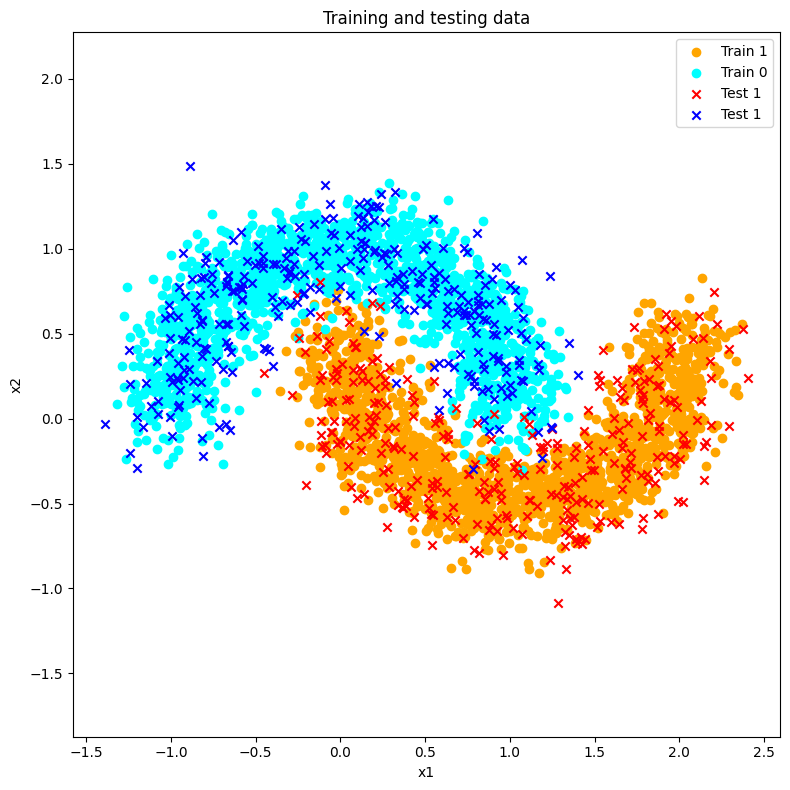

In [7]:
fig = plt.figure(figsize=(8, 8))
# Train data
cls_mask = train_split[1].astype(bool)
plt.scatter(train_split[0][cls_mask, 0], train_split[0][cls_mask, 1], color='orange', label='Train 1')
plt.scatter(train_split[0][~cls_mask, 0], train_split[0][~cls_mask, 1], color='cyan', label='Train 0')
# Test data
cls_mask = test_split[1].astype(bool)
plt.scatter(test_split[0][cls_mask, 0], test_split[0][cls_mask, 1], color='red', marker='x', label='Test 1')
plt.scatter(test_split[0][~cls_mask, 0], test_split[0][~cls_mask, 1], color='blue', marker='x', label='Test 1')

plt.title('Training and testing data')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()

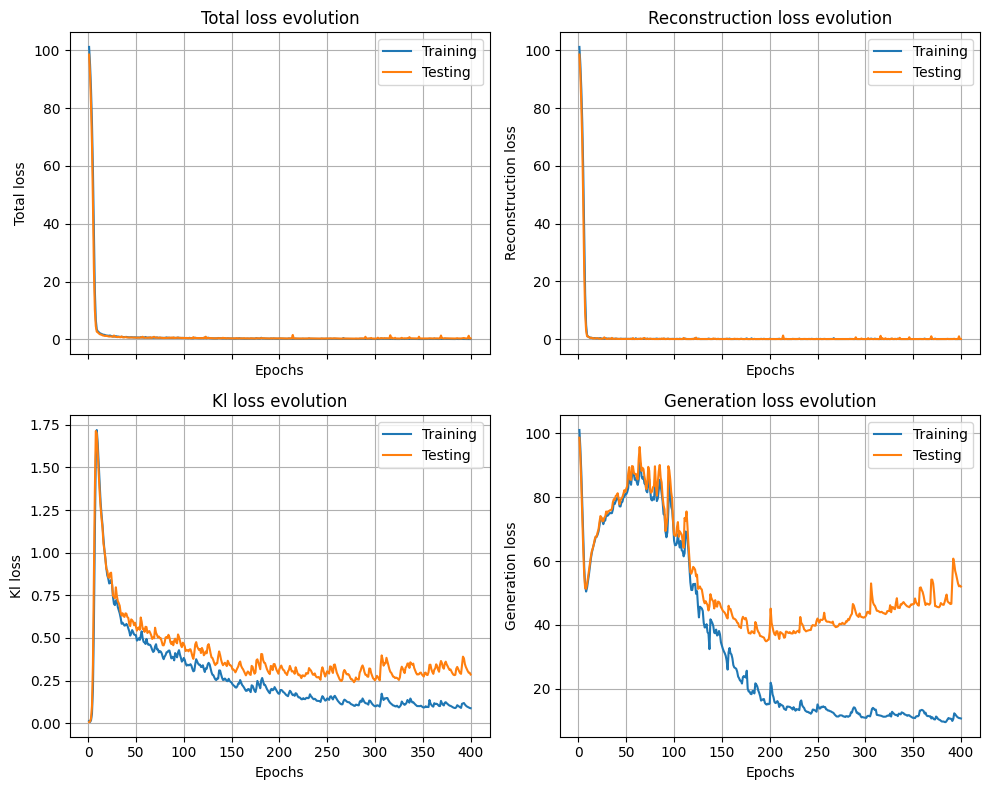

In [8]:
losses_label = ('total', 'reconstruction', 'kl', 'generation')

fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
axs = axs.ravel()

for i, loss_label in enumerate(losses_label):
    ax = axs[i]
    ax.plot(
        range(1, len(train_loss_history) + 1),
        [l[i] for l in train_loss_history],
        label='Training',
    )
    ax.plot(
        range(1, len(test_loss_history) + 1),
        [l[i] for l in test_loss_history],
        label='Testing',
    )
    ax.set_xlabel('Epochs')
    ax.set_ylabel(f'{loss_label.capitalize()} loss')
    ax.set_title(f'{loss_label.capitalize()} loss evolution')
    ax.grid()
    ax.legend()

plt.tight_layout()
plt.show()

## Latent space projection

In [9]:
def get_latent_space_projections(model: CVAE, dataloader: DataLoader):
    model.eval()
    prior_space = []
    xy_recog_space = []
    x1_recog_space = []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            prior_dist = model.prior(x)
            prior_space.append(prior_dist.mean.detach().cpu().numpy())
            xy_recog_dist = model.recognize(x, y)
            xy_recog_space.append(xy_recog_dist.mean.detach().cpu().numpy())
            x1_recog_dist = model.recognize(x, torch.ones_like(y))
            x1_recog_space.append(x1_recog_dist.mean.detach().cpu().numpy())
    prior_space = np.concatenate(prior_space, axis=0)
    xy_recog_space = np.concatenate(xy_recog_space, axis=0)
    x1_recog_space = np.concatenate(x1_recog_space, axis=0)
    return prior_space, xy_recog_space, x1_recog_space

In [10]:
prior_space, xy_recog_space, x1_recog_space = get_latent_space_projections(model_CVAE, test_loader)

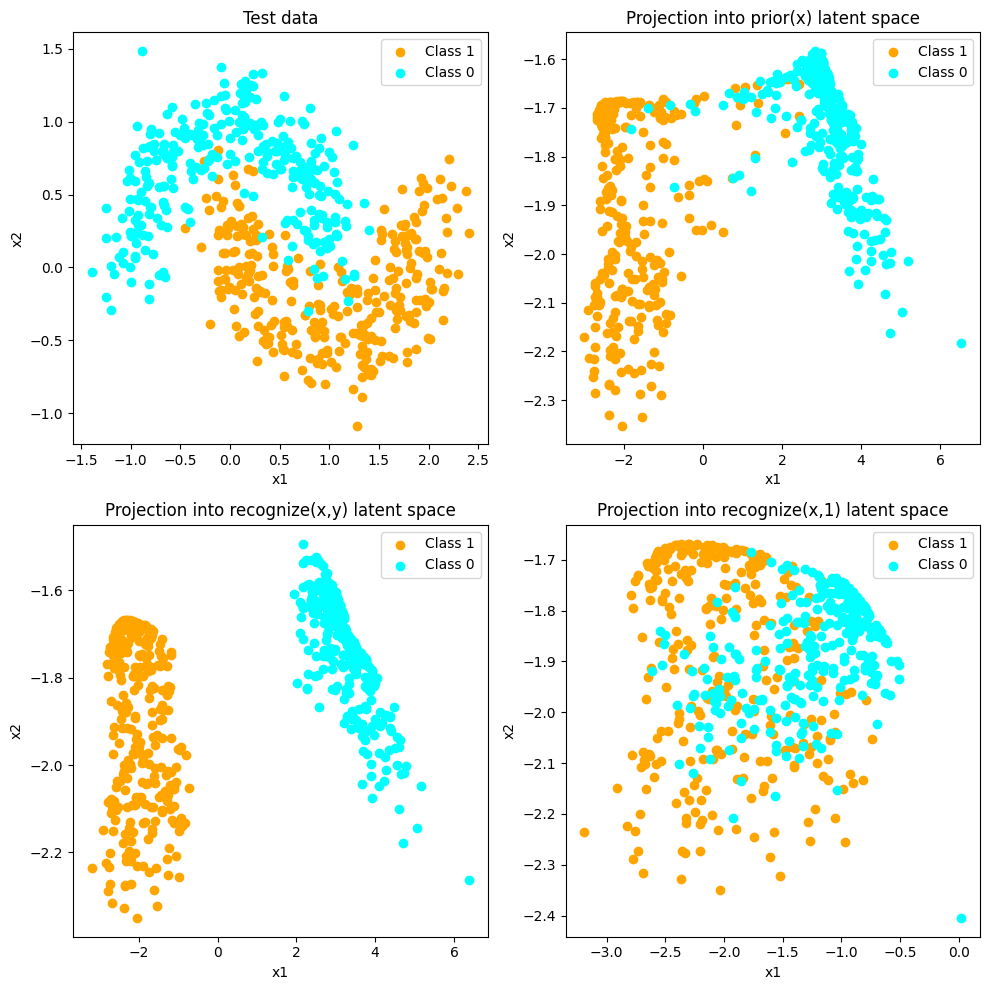

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
oax, pax, rxy_ax, rx1_ax = axs.ravel()

oax.scatter(test_split[0][cls_mask, 0], test_split[0][cls_mask, 1], label='Class 1', color='orange')
oax.scatter(test_split[0][~cls_mask, 0], test_split[0][~cls_mask, 1], label='Class 0', color='cyan')
oax.set_xlabel('x1')
oax.set_ylabel('x2')
oax.set_title('Test data')
oax.legend()

pax.scatter(prior_space[cls_mask, 0], prior_space[cls_mask, 1], label='Class 1', color='orange')
pax.scatter(prior_space[~cls_mask, 0], prior_space[~cls_mask, 1], label='Class 0', color='cyan')
pax.set_xlabel('x1')
pax.set_ylabel('x2')
pax.set_title('Projection into prior(x) latent space')
pax.legend()

rxy_ax.scatter(xy_recog_space[cls_mask, 0], xy_recog_space[cls_mask, 1], label='Class 1', color='orange')
rxy_ax.scatter(xy_recog_space[~cls_mask, 0], xy_recog_space[~cls_mask, 1], label='Class 0', color='cyan')
rxy_ax.set_xlabel('x1')
rxy_ax.set_ylabel('x2')
rxy_ax.set_title('Projection into recognize(x,y) latent space')
rxy_ax.legend()

rx1_ax.scatter(x1_recog_space[cls_mask, 0], x1_recog_space[cls_mask, 1], label='Class 1', color='orange')
rx1_ax.scatter(x1_recog_space[~cls_mask, 0], x1_recog_space[~cls_mask, 1], label='Class 0', color='cyan')
rx1_ax.set_xlabel('x1')
rx1_ax.set_ylabel('x2')
rx1_ax.set_title('Projection into recognize(x,1) latent space')
rx1_ax.legend()

plt.tight_layout()
plt.show()

## Predictions

### Using the prior network

In [12]:
def predict(model: CVAE, dataloader: DataLoader):
    model.eval()
    y_pred = []
    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            output = model.generate(x)
            y_pred.append(output.y.detach().cpu().numpy())
    y_pred = np.concatenate(y_pred, axis=0)
    return y_pred.flatten()

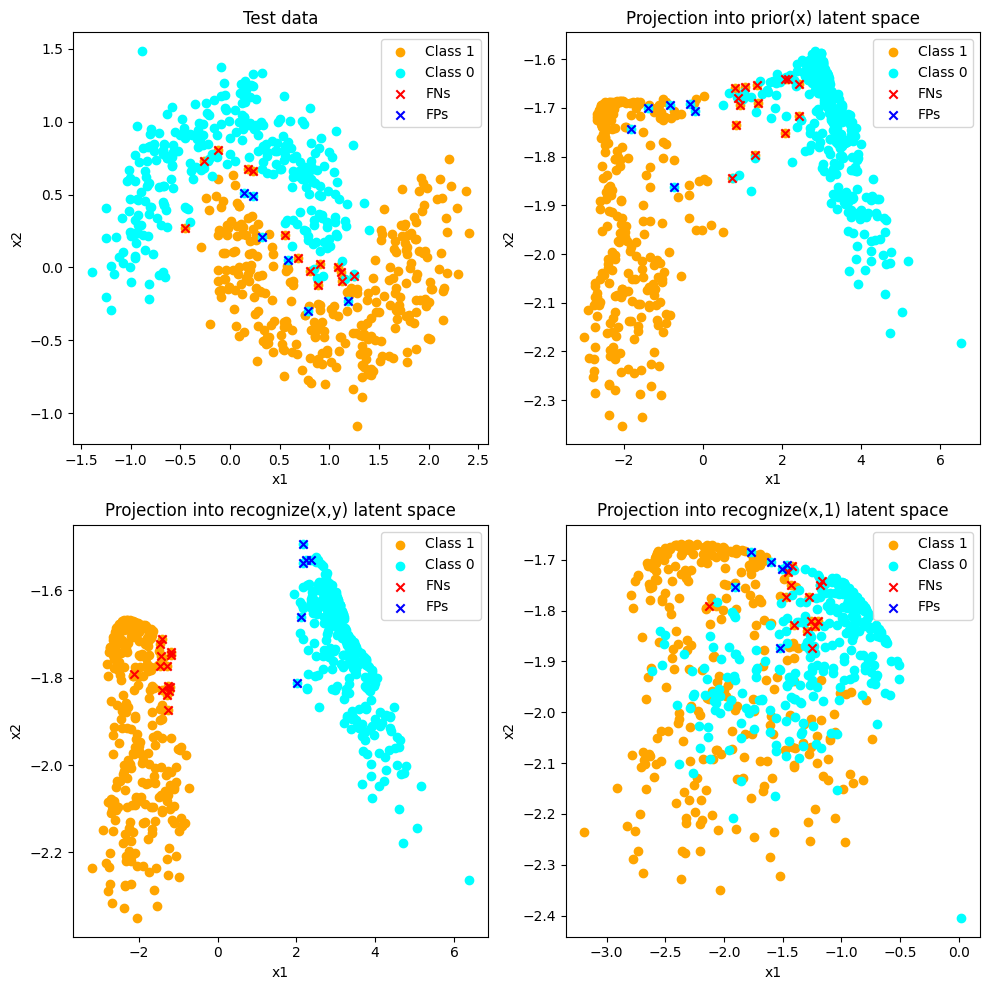

In [13]:
prior_y_pred = predict(model_CVAE, test_loader) > 0.5

prior_fns = np.logical_and(cls_mask, ~prior_y_pred)
prior_fps = np.logical_and(~cls_mask, prior_y_pred)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
oax, pax, rxy_ax, rx1_ax = axs.ravel()

oax.scatter(test_split[0][cls_mask, 0], test_split[0][cls_mask, 1], label='Class 1', color='orange')
oax.scatter(test_split[0][~cls_mask, 0], test_split[0][~cls_mask, 1], label='Class 0', color='cyan')
oax.scatter(test_split[0][prior_fns, 0], test_split[0][prior_fns, 1], label='FNs', color='red', marker='x')
oax.scatter(test_split[0][prior_fps, 0], test_split[0][prior_fps, 1], label='FPs', color='blue', marker='x')
oax.set_xlabel('x1')
oax.set_ylabel('x2')
oax.set_title('Test data')
oax.legend()

pax.scatter(prior_space[cls_mask, 0], prior_space[cls_mask, 1], label='Class 1', color='orange')
pax.scatter(prior_space[~cls_mask, 0], prior_space[~cls_mask, 1], label='Class 0', color='cyan')
pax.scatter(prior_space[prior_fns, 0], prior_space[prior_fns, 1], label='FNs', color='red', marker='x')
pax.scatter(prior_space[prior_fps, 0], prior_space[prior_fps, 1], label='FPs', color='blue', marker='x')
pax.set_xlabel('x1')
pax.set_ylabel('x2')
pax.set_title('Projection into prior(x) latent space')
pax.legend()

rxy_ax.scatter(xy_recog_space[cls_mask, 0], xy_recog_space[cls_mask, 1], label='Class 1', color='orange')
rxy_ax.scatter(xy_recog_space[~cls_mask, 0], xy_recog_space[~cls_mask, 1], label='Class 0', color='cyan')
rxy_ax.scatter(xy_recog_space[prior_fns, 0], xy_recog_space[prior_fns, 1], label='FNs', color='red', marker='x')
rxy_ax.scatter(xy_recog_space[prior_fps, 0], xy_recog_space[prior_fps, 1], label='FPs', color='blue', marker='x')
rxy_ax.set_xlabel('x1')
rxy_ax.set_ylabel('x2')
rxy_ax.set_title('Projection into recognize(x,y) latent space')
rxy_ax.legend()

rx1_ax.scatter(x1_recog_space[cls_mask, 0], x1_recog_space[cls_mask, 1], label='Class 1', color='orange')
rx1_ax.scatter(x1_recog_space[~cls_mask, 0], x1_recog_space[~cls_mask, 1], label='Class 0', color='cyan')
rx1_ax.scatter(x1_recog_space[prior_fns, 0], x1_recog_space[prior_fns, 1], label='FNs', color='red', marker='x')
rx1_ax.scatter(x1_recog_space[prior_fps, 0], x1_recog_space[prior_fps, 1], label='FPs', color='blue', marker='x')
rx1_ax.set_xlabel('x1')
rx1_ax.set_ylabel('x2')
rx1_ax.set_title('Projection into recognize(x,1) latent space')
rx1_ax.legend()

plt.tight_layout()
plt.show()

### Using the recognition network

In [14]:
def importance_predict(model: CVAE, dataloader: DataLoader, num_samples: int = 5):
    model.eval()
    y_pred = []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y_hyp = torch.ones_like(y).to(device)
            recog_dist = model.recognize(x, y_hyp)
            prior_dist = model.prior(x)
            batch_y_pred = 0.0
            for _ in range(num_samples):
                z = recog_dist.sample()
                sample_probs = model.reconstruct(x, z).flatten()
                sample_probs *= torch.exp(prior_dist.log_prob(z)) / num_samples
                sample_probs /= torch.exp(recog_dist.log_prob(z))
                batch_y_pred += sample_probs
            y_pred.append(batch_y_pred.detach().cpu().numpy())
    y_pred = np.concatenate(y_pred, axis=0)
    return y_pred.flatten()

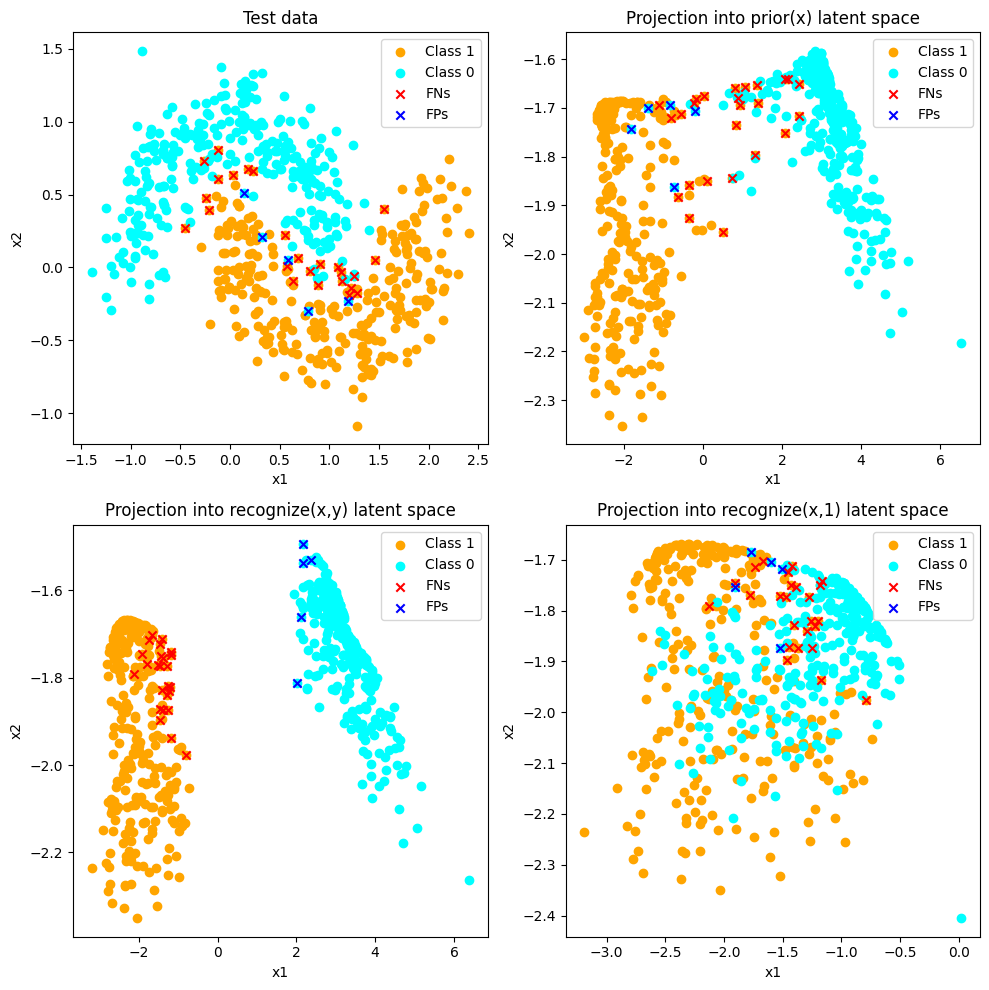

In [15]:
recog_y_pred = importance_predict(model_CVAE, test_loader) > 0.5

prior_fns = np.logical_and(cls_mask, ~recog_y_pred)
prior_fps = np.logical_and(~cls_mask, recog_y_pred)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
oax, pax, rxy_ax, rx1_ax = axs.ravel()

oax.scatter(test_split[0][cls_mask, 0], test_split[0][cls_mask, 1], label='Class 1', color='orange')
oax.scatter(test_split[0][~cls_mask, 0], test_split[0][~cls_mask, 1], label='Class 0', color='cyan')
oax.scatter(test_split[0][prior_fns, 0], test_split[0][prior_fns, 1], label='FNs', color='red', marker='x')
oax.scatter(test_split[0][prior_fps, 0], test_split[0][prior_fps, 1], label='FPs', color='blue', marker='x')
oax.set_xlabel('x1')
oax.set_ylabel('x2')
oax.set_title('Test data')
oax.legend()

pax.scatter(prior_space[cls_mask, 0], prior_space[cls_mask, 1], label='Class 1', color='orange')
pax.scatter(prior_space[~cls_mask, 0], prior_space[~cls_mask, 1], label='Class 0', color='cyan')
pax.scatter(prior_space[prior_fns, 0], prior_space[prior_fns, 1], label='FNs', color='red', marker='x')
pax.scatter(prior_space[prior_fps, 0], prior_space[prior_fps, 1], label='FPs', color='blue', marker='x')
pax.set_xlabel('x1')
pax.set_ylabel('x2')
pax.set_title('Projection into prior(x) latent space')
pax.legend()

rxy_ax.scatter(xy_recog_space[cls_mask, 0], xy_recog_space[cls_mask, 1], label='Class 1', color='orange')
rxy_ax.scatter(xy_recog_space[~cls_mask, 0], xy_recog_space[~cls_mask, 1], label='Class 0', color='cyan')
rxy_ax.scatter(xy_recog_space[prior_fns, 0], xy_recog_space[prior_fns, 1], label='FNs', color='red', marker='x')
rxy_ax.scatter(xy_recog_space[prior_fps, 0], xy_recog_space[prior_fps, 1], label='FPs', color='blue', marker='x')
rxy_ax.set_xlabel('x1')
rxy_ax.set_ylabel('x2')
rxy_ax.set_title('Projection into recognize(x,y) latent space')
rxy_ax.legend()

rx1_ax.scatter(x1_recog_space[cls_mask, 0], x1_recog_space[cls_mask, 1], label='Class 1', color='orange')
rx1_ax.scatter(x1_recog_space[~cls_mask, 0], x1_recog_space[~cls_mask, 1], label='Class 0', color='cyan')
rx1_ax.scatter(x1_recog_space[prior_fns, 0], x1_recog_space[prior_fns, 1], label='FNs', color='red', marker='x')
rx1_ax.scatter(x1_recog_space[prior_fps, 0], x1_recog_space[prior_fps, 1], label='FPs', color='blue', marker='x')
rx1_ax.set_xlabel('x1')
rx1_ax.set_ylabel('x2')
rx1_ax.set_title('Projection into recognize(x,1) latent space')
rx1_ax.legend()

plt.tight_layout()
plt.show()

### Confusion matrices

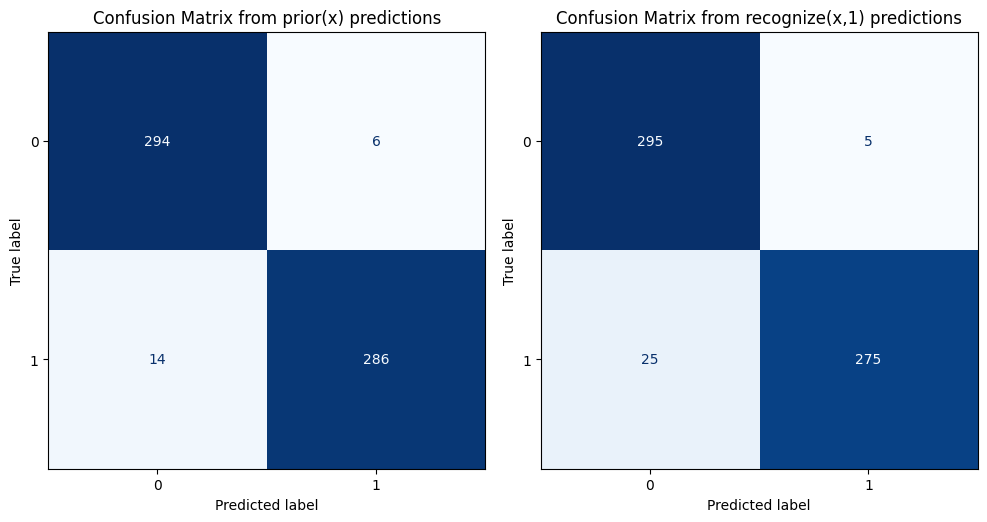

In [16]:
prior_tns = np.logical_and(~cls_mask, ~prior_y_pred).sum()
prior_fps = np.logical_and(~cls_mask, prior_y_pred).sum()
prior_fns = np.logical_and(cls_mask, ~prior_y_pred).sum()
prior_tps = np.logical_and(cls_mask, prior_y_pred).sum()
prior_cmatrix = np.array([[prior_tns, prior_fps], [prior_fns, prior_tps]])

recog_tns = np.logical_and(~cls_mask, ~recog_y_pred).sum()
recog_fps = np.logical_and(~cls_mask, recog_y_pred).sum()
recog_fns = np.logical_and(cls_mask, ~recog_y_pred).sum()
recog_tps = np.logical_and(cls_mask, recog_y_pred).sum()
recog_cmatrix = np.array([[recog_tns, recog_fps], [recog_fns, recog_tps]])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

display = ConfusionMatrixDisplay(prior_cmatrix)
display.plot(ax=axs[0], colorbar=False, cmap='Blues')
axs[0].set_title(f'Confusion Matrix from prior(x) predictions')

display = ConfusionMatrixDisplay(recog_cmatrix)
display.plot(ax=axs[1], colorbar=False, cmap='Blues')
axs[1].set_title(f'Confusion Matrix from recognize(x,1) predictions')

plt.tight_layout()
plt.show()